In [2]:
setwd('C:/Users/Mhuth/Desktop/PCRPVA') #only for local computations
files <- c('PCA_PropVar', 'PCA', 'PCR_cv', 'PCR_predict', 'PCR', 'random_discreteVariables', 'random_VCV', 'DGP_function') #names of files to read
for (i in 1:length(files)) { #loop to read all files
    source(paste('R/', files[i], '.R', sep = '')) 
}

#install.packages('dagitty')
library(dagitty)

# 1. Introduction

In economics one is often interested in structural modelling that abstracts real world dependencies in a realistic theoretical set-up. For example Blundell et al. [(2016)](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA11576?casa_token=T7_8JfSc3V0AAAAA:Rq3dQoE4CwRQ5bmOvmvwz1RfUnzp7wYh3LRtrMZsrJjKhrefbBItL0gdFcdZLiYVB-33AUya90S8wTfy) examine how female labour supply and human capital accumulation are affected by tex credit reforms or understanding, inter alia, the dependencies of schooling and wages as in Fan et al. [(2015)]. In the latter paper, the authors estimate a key reduced form equation that is similar to the original Mincer Equation (Mincer, [1974](https://eric.ed.gov/?id=ED103621)). The latter has been studied extensively in the economic literature, see Heckman et al. [(2006)]((https://www.sciencedirect.com/science/article/pii/S1574069206010075) for a more recen review. Depending on the chosen covariates, models estimateing wages have to deal with highly multicollinear data and thus high variances of OLS coefficients that lead to high variances of the outcome estimates. For the outcome estimate it is desirable to have a low variance yielding a reliable estimate of the counterfactual outcome. Reducing the variance can be adressed using applying principal components. First the principal component analysis is performed. By computing orthogonal projections of the original data such that the variance of the original data is inherited in the projections (James et al., [2013](https://link.springer.com/book/10.1007%2F978-1-4614-7138-7)) one is able to leave out some of the projections. Subsequent, an OLS regression is performed using the chosen projections. Since the projections are uncorrelated the issue of high multicollinearity is solved. The projection matrix consists of eigenvectors of the Variance covariance matrix and is therefore unique up to a sign flip of the projections (Jollife, [1986](https://link.springer.com/chapter/10.1007/978-1-4757-1904-8_8)). In practice this variance covariance matrix is not known and must be esimated using the given sample and thus the projection matrix is also an estimate. 

In this notebook I examine if the estimation of projection matrix increaes the variance of the regression coefficients and thus the variance of the estimated outcome relative to the variances obtained by using the true projection matrix. I do so by simulating data for an equation in style of the Mincer Equation, that sets wages in dependency to highly correlated covariates and should mimic data created by a proper structural model. Subsequent I derive that simualting the empirical distribution of the principal component regression coefficients is, due to the non-uniqueness of the projection matrix in the case of the estimated projection, not suitable to derive the unconditional variance of the estimated coefficients. I present another simulation strategy, to obtain proper variances of the estimates, that builds up on some algebra, and justify this strategy by comparing both cases using the true projection matrix. Finally, I compare the variances of the coefficients of the true and of the estimated projection matrix and find that there is no substantial difference. Furtermore, I check if this leads really leads to no difference in the variance of the estimated outcome and find that there is indeed no substantial difference.
  
For a note of completeness, principal component regression is usually also applied as a method for dimension reduction. Picture a high-dimensional case with many predictors $p$ and $n$ data points. If $n >p$ OLS cannnot be applied and if $p \leq n$ with a small difference in $p$ and $n$ OLS tends to overfit the data, yielding bad prediction results. This issue can be solved by choosing only a few of the principal components for the principal component regression. In this case, principal component regression can outperform OLS in a substantial manner (James et al., [2013](https://link.springer.com/book/10.1007%2F978-1-4614-7138-7)). However, I only examine the case of high multicollinearity and the variances of the estimates in this notebook leaving the additional analysis of high-dimensional data as a desirable feature for further analysis.

Many non-economics examples, e.g. how principal component analysis can help to study the motion of a ball's ideal spring without any knowledge of physics (Shenly, [2005](https://www.cs.cmu.edu/~elaw/papers/pca.pdf)) or how it can help to detect presence of disturbances in chemical processes (Ku et al., [2013](https://www.sciencedirect.com/science/article/pii/0169743995000763)) can be found in the literature and show that principal component analysis and regression have a broad class of applications.
    
The structure of the notebook is the following. In section 2 I introduce how the data is build to yield the desirable features of the analysis. Subsequent, I show in section 3 how the principal components can be derived, how the principal component regression is applied and discuss two techniques to derive the variance of the estimatros using a simulation study. In section 4, the simulation study, I simulate the data using the data generating process proposed in section 1, compare the two techniques to derive the variance of the estimates and finally compare the variances of the coefficient estimates and the outcome estimates using the proper technique. Section 5 concludes and proposes extensions for further analysis. The appendix consists of calculations and further justifications that would have decreased readability of the main part.

---
# 2. Model
---

## 2.1 Baseline Equation of Wages

To model the real hourly wages of an individual $i$ I follow the well-known Mincer Equation (Mincer, [1974](https://eric.ed.gov/?id=ED103621)), that models the logarithmic wage as linear function of schooling and work experience as a second order polynomial. Additionally, I add the number of siblings and the years of parent's education and interprete the individual intercept coefficient as a persons ability. I follow Björklund and Kjellström [(2002)](https://www.sciencedirect.com/science/article/abs/pii/S0272775701000036) and divide the squared work experience by 100 to have more numerical stability. The notation is the following

- $Y_i:=$ log-hourly wage of individual i
- $\alpha:=$ constant term for all individuals
- $a_i:=$ individual's ability  
- $s_i :=$ individual's years of schooling
- $w_i := $ individual's work experience
- $n_i:= $ number of Siblings
- $e_i:= $ parent's years of education
- $\varepsilon_i:= $ normally distributed error and uncorrelated with the other variables.
- $T_{i,g,c}:= $ individual's test score in grade $g$ of subject $c$   

\begin{align}
\ln (Y_i) = \alpha + a_i + \beta_1 s_i  + \beta_2 w_i + \beta_3 \frac{w_i^2}{100} + \beta_4 n_i + \beta_5 e_i + \varepsilon_i
\tag{2.1}
\end{align}

Since ability is not observable in the real world, I use math and reading test scores from the seventh and eleventh grade as a proxy variable in the analysis. I have chosen this type of model since it is well-known and well-analyzed (see inter alia: Heckman et al., [2006](https://www.sciencedirect.com/science/article/pii/S1574069206010075); Lemieux, [2006](https://link.springer.com/chapter/10.1007/0-387-29175-X_11)) and all the covariates are (highly) correlated. Thus it provides a well-fitting set-up to examine the question whether the variance of the parameter estimates and the outcome estimates increases, if the true variance-covaraince matrix of the regressors is unknown in principal components regression. For the sake of this principal component analysis, I have omitted regional or gender specific dummy variables. However, it would be interesting to incorporate them in further analysis.

## 2.2 Data Generating Process

Setting up the data generating Process, I faced three main issues 

1. there should be a reasonable correlation structure between the variables
2. there should not be impossible values, e.g. negative count variables
3. benchmark population moments from Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ) should be met

My strategy was to first deterine the dependencies (given in *Figure 1*), then determining the respective scaling of all variables (*Table 1*) and finally determine equations to impose a structure that meets the given population moments and the dependency structure (subsection *2.3.3*). 

### 2.2.1 Dependency Structure (Causal Graph)
The dependency structure can best be illustrated using a causal graph. Most relationships are straightforward. Parent's with high eduaction usually have fewer children (Cygan-Rehm and Maeder, [2013](https://www.sciencedirect.com/science/article/abs/pii/S0927537113000584)), ability influences test scores (Hansen et al., [2004](https://www.sciencedirect.com/science/article/pii/S0304407603002598)) and parents with education tend to have children with more schooling years (Davis-Kean and Pamela, [2005](https://psycnet.apa.org/buy/2005-06518-016)). A key assumption I make is that ability is random and not affected by any other variable, e.g. parent's education. This assumption facilitates the derivation of the parameterization of the model, especially of the number of years of schooling of an individual, and seemed reasonable for the purposes of my data generating process. 

**Figure 1 - Causal Graph** 

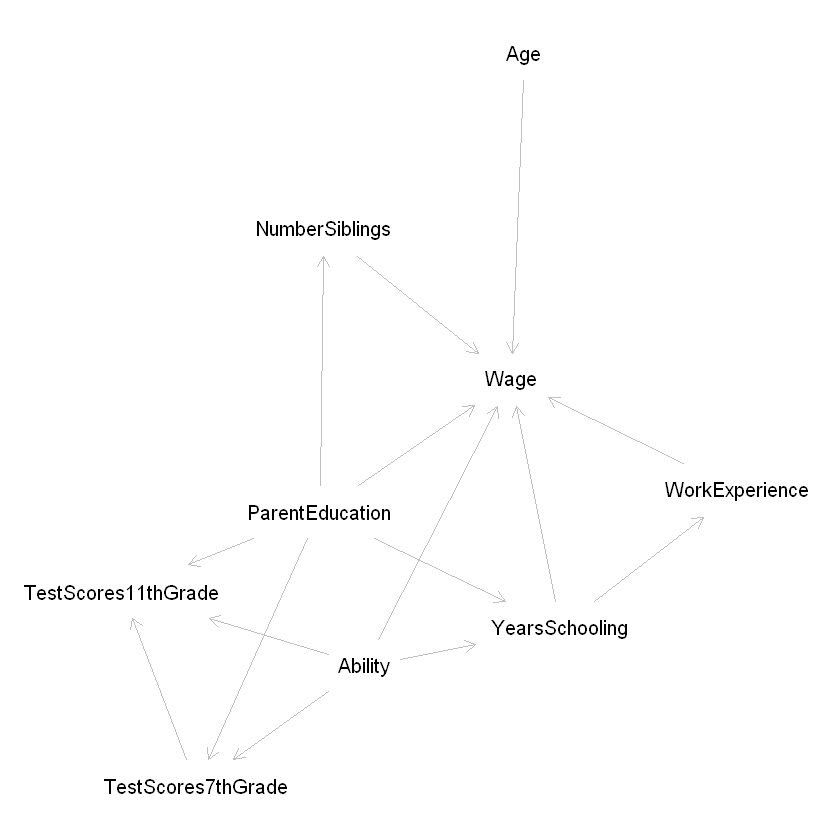

In [4]:
causal_graph <- dagitty("dag {
Ability -> TestScores7thGrade Ability Ability -> TestScores11thGrade Ability -> YearsSchooling Ability -> Wage
TestScores7thGrade -> TestScores11thGrade 
ParentEducation -> TestScores7thGrade ParentEducation -> TestScores11thGrade ParentEducation -> NumberSiblings ParentEducation -> YearsSchooling
YearsSchooling -> WorkExperience YearsSchooling -> Wage
NumberSiblings -> Wage ParentEducation -> Wage
WorkExperience -> Wage
Age -> Wage
}")
set.seed(9)
plot(graphLayout(causal_graph))

### 2.2.3 Scaling of the Variables

To have a realistic data generating process set up, it is necessary that the variables have the right scaling, e.g. negative values for the count variables schooling, work experience and number of siblings and for the wage must be avoided. The latter is already incorporated in equation *(1.1)* by using the logarithmic value of the wages as depedent variable. Moreover, test Scores should be distributed in an interval that is bounded below and above or even following an ordinal scale. Since Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ) report the share of individuals in each of the quintiles, I decided to allow for grades between 5 (best) and 1 (worst). Since there is no natural scaling for ability, I assume that ability can possibly take any real value. The scaling is therefore

**Table 1 - Scaling of the Variables**

| Variable | Scaling of Variable  |
|------|------|
|   Wages  | $\mathbb{R}_+  $|
|   Ability  | $\mathbb{R}  $|
|   Test Scores  | $\{1,2,3,4,5 \}  $|
|   Schooling  | $\mathbb{N}_0  $|
|   Work Experience  | $\mathbb{N}_0  $|
|   Number of Siblings  | $\mathbb{N}_0  $|
|   Parent's Years of Education  | $\mathbb{N}_0  $|

I use the derived dependency structure and scaling to build the fundamentals for the DGP in the next subsection.

### 2.3.3 Equations of the Data Generating Process 

The causal graph given above is the fundament of my strategy to create the data. Every variable is dependent on each variable that has an arrow pointing at it. Summing up this structure in general equations yields 

\begin{align}
    Y_i =& f_0(a_i, s_i, w_i, n_i, e_i)\\
    T_{i,7,c} =& f_1\left(a_i, e_i \right) \\
    T_{i,11,c} =& f_2\left(a_i, e_i, T_{i,7,c} \right)\\
    s_i =& f_3(a_i, e_i) \\
    w_i =& f_4(s_i) \\
    n_i =& f_5(e_i) \\
    \tag{2.2}
\end{align}

whereby $f_j$ is a function that models the relationship between the dependent and independent variable. Note that $f_0$ is already determined in equation *(2.1)*. My aim is now to find reasonable forms for the $f_j$ such that parametrizations meet the requirements for a realistic data generating process derived in the previous subsections. Thus, I first determine parent's education and ability, since they are not caused by other variables. Subsequently, I use the imposed assumptions to build the data step by step. 

The structure I use is very similar for every step. I use the population moments, set them equal to the theoretical moments from the assumed distributions and solve for the characeristic parameters of the respective distribution. In the simulation I use this computed parameterizations to approximate the population moments given in Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ). A full overview of the parameterization, sources and justifications is given in the appendix *A.10*.  

**Parents' Education**

Since the years of parent's schooling is not caused by any other variable and is positive integer valued, I decided to draw $N$ independent times from a Generalized Poisson distribution. The distribution yields only non-negative integers and allows, other than the Poisson distribution, for overdispersion in the data. Following Jung and Tremayne [(2010)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9892.2010.00697.x?casa_token=Z_aij9JL6U0AAAAA%3APnfZIk7h3P8Jzs4pVvW-Hmd1mswaOAMW-5KbW6G6YV3uEQiXvbrT7ZH8pGHJqiSed7ofNfkwSbgb2hfx), I denote the generalized Poisson distribution for parent's education with parameters $\lambda_e \in \mathbb{R}_+$ and $\eta_e \in [0,1)$ by $GP(\lambda_e, \eta_e)$. The probability mass function is given by

\begin{align}
Prob\left(E = e\right) = \frac{\lambda(\lambda + e \eta)^{e-1} \cdot \exp{\left[-(\lambda + e \eta) \right]}}{e!},
\tag{2.3}
\end{align}

The first and second moment can be expressed by the introduced parameters as $\text{E}(e_i) = \frac{\lambda_e}{1-\eta_e}$ and $\text{Var}(e_i) =\frac{\lambda_e}{(1-\eta_e)^3}$. Setting $\eta_e = 0$ yields the ordinary Poisson distribution and therefore the setting allows to use the nested Poisson distribution by adjusting $\eta$. For a full summary of the distribution I reference to Consul and Jain [(1973)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1973.10489112).\
To find the parameterization that suits the first and second population moments of Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ), I set the expected outcome of one individual equal to the population mean $\mu_e$ and the variance equal to the population variance $\sigma_e^2$. Subsequent, I solve this system of two equations for $\lambda_e$ and $\eta_e$. 

\begin{align}
    \sigma_e^2 = \text{Var}(e_i) = \frac{\lambda_e}{(1-\eta_e)^3} =  \frac{\text{E}(e_i)}{(1-\eta_e)^2} = \frac{\mu_e}{(1-\eta_e)^2} \Longleftrightarrow \eta_e = 1 - \frac{\sqrt{\mu_e}}{\sigma_e} \Longrightarrow \lambda_e = \frac{\mu_e^{1.5}}{\sigma_e}
    \tag{2.4}
\end{align}

A note of notation, for subsequent derivations I denote the distribution function of $e_i$ by $D_{e}$ for all $i = 1, \dots, N$.

**Ability**

Since there is no clear scaled measure for ability and hence I cannot match the distribution to population means, I decided to usa a normal distribution with mean zero, such that $a_i \sim \mathcal{N}\left(0, \sigma^2_{ability}\right)$. It seemed reasonable to me that that most individuals have similar abilities but there are some individuals with very low or very high abilities. As parent's education, ability is not caused by any other variable and can therefore be drawn $N$ independent times from the stated normal distribution.

Since I will make use of this when I define the process for the years of schooling, I denote the cumulative distribution function of $a_i$ by $\phi_a$ for all $i = 1, \dots, N$. 

**Age**

I assume that individuals are aged between 33 and 68 years. The former is the age of the individuals in Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ) and the latter is the UKs state pension age (British Government, [2018](https://www.gov.uk/state-pension-age)). The age distribution is derived from the Office for National Statistics [(2020)](https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2015/ukandregionalpopulationestimates18382015.zip) data on how many people lived in the United Kingdom per each year of age in 1991. I use the total number of individuals aged between 33 and 68 and compute the relative frequency per year to create a sample that uses the computed values as true probabilities and draw $N$ independent times from this discrete distribution. For this purposes I used my user written functions that allow generating discrete random variables given a specific probability mass. They can be found in the repository on [GitHub](https://github.com/manuhuth/PCR-Parameter-Variance-Analysis/blob/master/R/random_discreteVariables.R).

**Test Scores**

As the individuals in Blunell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ). Individuals in my data take two tests in reading and math in the seventh and eleventh grade. To build the test scores, I follow Hansen et al. [(2004)](https://www.sciencedirect.com/science/article/abs/pii/S0304407603002598) and determine the test scores as a function of ability. Moreover, I found it reasonable to add parent's education to account for parental influence on the children's test scores. Since in Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ) the relative frequency of the quintiles is given, I decided that individuals can score from 5 (best) to 1 (worst). The problem that test scores are integer valued is solved in Hansen et al. [(2004)](https://www.sciencedirect.com/science/article/abs/pii/S0304407603002598) by rounding the test scores (on a scale up to 100) to meet the integer requirement. However, since my scaling of test scores only consists of five numbers, I chose a different approach that builds on the property that the cumulative distribution function of a random variable is uniform distributed (*A.10*) to prevent that rounding changes the population frequencies of the grades. From equations *(2.2)* it follows that the test scores are a function of ability and parent's education. First, I model a continous latent process $T^*_{i, g, c}$ for every test, whereby $g \in \{7,11 \}$, $c \in \{ \text{math}, \text{reading}\}$, $i = 1, \dots, N$. The latent test scores for the 7th grade tests are defined as a linear function of ability and to a normal ditribution transformed parent's education

\begin{align}
T^*_{i,7,c} = \gamma_{ability} \cdot a_i + \gamma_{parent} \cdot \underbrace{\phi^{-1}_a\left(\underbrace{D_e(e_i)}_{\sim unif(0,1)}\right)}_{\sim \mathcal{N}(0,\sigma_{ability}^2)}  + \varepsilon_{i,7,c} ,
\tag{2.5}
\end{align}

whereby I assume that  $\varepsilon_{i,7,c} \sim \mathcal{N}(0, \sigma^2_7)$ and uncorrelated with ability and parent's education. To derive that $D_e(e_i)$ is uniform and $\phi^{-1}_a\left(D_e(e_i)\right)$ is normal, I make use of that the distribution function of a random variable is uniform distributed, which is proven in the appendix *A.6*. Thus, I scale the variable to a uniform distribution and interprete the $N$ values of of this as $N$ independent draws from a uniform distribution. By applying the the inverse of the normal distribution with the population moments from parent's education as distribution moments, I generate a normally distributed variable that meets the requiremets of the population moments. Hence, this newly created variable inherits the structure of individual's parent's education, thus the general correlation structure, and also meets the parent's education population moments. It would be desirable for further analysis to examine how the correlation structure is inherited by this transformation and how this could be applied to other approaches of modelling. The advantage is that with this transformation the distribution of the latent test scores exist in closed form, $T^*_{i,7,c} \sim \mathcal{N}\left(0, (\gamma_{ability}^2 + \gamma_{parent}^2) \sigma^2_{ability} + \sigma_7^2 \right)$ with distribution function $\phi_7$, which is needed subsequent to compute the grade frequencies. Moreover, it turns out that in the applicaton the specification allows to model the desired correlation structure. 

Since the latent test score's distribution is known in closed form, the same trick can be applied again to transform the latent test score to a uniform distributed variable. In notation that means $\phi_7 \left( T^*_{i,7,c} \right)$ is uniform distributed. Frome here on, it is possible to give the test scores any desired distribution, since any variable can be simulatd from a uniform distribution using appendix *A.6* vice versa. Defining the k-th quintiles of test scores of the test in $c$ in seventh grade by $q^k_{7,c}$, I obtain the test scores by allocating the individuals according to their transformed latent test score 

\begin{align}
T_{i,7,c} = \begin{cases}
1 &, 0 \leq \phi_7  \left( T^*_{i,7,c} \right) \leq q^1_{7,c} \\
2 &, q^1_{7,c} <  \phi_7  \left( T^*_{i,7,c} \right) \leq \sum_{k=1}^2 q^k_{7,c} \\
3 &, \sum_{k=1}^2 q^k_{7,c} < \phi_7 \left( T^*_{i,7,c} \right) \leq \sum_{k=1}^3 q^k_{7,c}\\
4 &, \sum_{k=1}^3 q^k_{7,c} < \phi_7 \left( T^*_{i,7,c} \right) \leq \sum_{k=1}^4 q^k_{7,c}\\
5 &, \sum_{k=1}^4 q^k_{7,c} < \phi_7 \left( T^*_{i,7,c} \right) \leq 1\\
\end{cases}
\tag{2.6}
\end{align}

Moving to further stages of their education, the individuals in my model take a new test and score the same latent value as in the 7th grade plus/minus a stochastic error $\varepsilon_{i,11,c} \sim \mathcal{N}(0, \sigma_{11}^2)$. The correlation between the test scores can be determined by increasing (lower correlation) or decreasing (higher correlation) the variance of the error term. In the application I chose a rather high variance of 11 for the error to set the correlation between the two test scores to around 0.9. A higher correlation lead to perfect multicollinearity of the test scors in some small samples.

\begin{align}
T^*_{i,11,c} = T^*_{i,7,c} + \varepsilon_{i,11,c}
\tag{2.7}
\end{align}

Hence, $T^*_{i,11,c} \sim \mathcal{N}\left(0,  (\gamma_{ability}^2 + \gamma_{parent}^2) \sigma^2_{ability} + \sigma_7^2 + \sigma_{11}^2 \right)$. To obtain the test scores, I apply the same transformation as in equation *(2.6)*. Note that this transforming ensures flexibility to allow basically any distribution of grades for the test scores in secenth or eleventh grade and both subjects.

**Number of Siblings**

To determine the structure of $f_5$, I have used a model that is similar to the ones used for integer valued count data models, see (Jung and Tremayne, [2010](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9892.2010.00697.x?casa_token=Z_aij9JL6U0AAAAA%3APnfZIk7h3P8Jzs4pVvW-Hmd1mswaOAMW-5KbW6G6YV3uEQiXvbrT7ZH8pGHJqiSed7ofNfkwSbgb2hfx)). Economic literature argues that higher educated individuals have fewer children because the demand of children decreases with higher educatuion, due to increasing opportunity costs (see inter alia: Willis, [1973](https://www.journals.uchicago.edu/doi/abs/10.1086/260152?journalCode=jpe); Bailey, [2010](https://www.aeaweb.org/articles?id=10.1257/aer.100.1.98)). Cygan-Rehm and Maeder [(2013)](https://www.sciencedirect.com/science/article/abs/pii/S0927537113000584) found that one additional year of education reduces the expected number of children of around 0.1. I have built an equation that can account for this by preserving the count structure of the data and takes into account that higher educated parents are expected to have fewer children. For every individual $i$ I draw the maximum possible years of education minus the years of their parent's education independent bernoulli experiments with success probability $p$ and add an independent error term $W_i^{sib} \sim GP(\lambda^{sib}, \eta^{sib})$.  

\begin{align}
n_i = \sum_{j = 1}^{m-e_i} B_{ij} + W_i^{sib}, 
\tag{2.8}
\end{align}

$m$ is the maximum years of parent's education, $B_{ij} \sim \mathcal{B}(p)$ is Bernoulli distributed. The sum of $B_{ij}$ and $W_i^{sib}$ are independent. Since the error is assumed to be independent of all the bernoulli trials $\text{E}(W_i^{sib}) = \text{E}(W_i^{sib}|e_i)$. Moreover, the sum of the indepdendent bernoulli trials is, conditioned on parent's education, binominal distributed $\sum_{j = 1}^{m-e_i} B_{ij} | e_i \sim Bin(m-e_i, p)$. Thus, the expected difference in a one year increase in parent's education can be computed by  $=\text{E}(n_i|e_i + 1) - \text{E}(n_i| e_i) = (m - e_i - 1)p + \text{E}(W_i^{sib}) - (m - e_i)p - \text{E}(W_i^{sib}) = - p$, such that one additional year of parent's education decreases the expected number of siblings by $p$. 
The imposed structure has the benefit that, similar as done before, it can be parameterized such that the first two moments of the random variable $n_i$ meet the population moments reported in Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ) by computing $\lambda^{sib}$ and $\eta^{sib}$ according to the desired moments. A full derivation can be found in the appendix *A.7*.

\begin{align}
\eta^{sib} =&  1 - \left(\frac{\mu_n - (m - \mu_{e}) \cdot p}{\sigma^2_n - (m-\mu_e)\cdot p \cdot (1-p) + p^2 \cdot \sigma^2_s}\right)^{0.5}\\
\lambda^{sib} =& [\mu_n - (m - \mu_{e}) \cdot p] \cdot (1-\eta^{sib}),
\tag{2.9}
\end{align}

whereby $\mu_n$ and $\sigma^2_n$ are the first and second moment of the number of siblings.

**Years of schooling**

The structure I impose is similar to the one for the number of siblings including one bernoulli experiment for every year of parent's education and an additive error. To account for ability in the years of schoolin, the error in my model is dependent on an individuals ability, such that $W^{sch}_i |a_i \sim GP(\lambda_i^\text{sch}, \eta^{sch})$ and $\lambda_i = k \cdot \phi_a(a_i)$, whereby $k \in \mathbb{R}$. Since ability and parent's education are assumed to be independent, the error is independent from the sum of the bernoulli experiments. Using *A.6*, a cumulative distribution function is uniform distributed, it follows that $\lambda_i^{sch} \sim unif[0, k]$ and thus $\text{E}(\lambda_i^{sch}) = \frac{k}{2}$ and $\text{Var}(\lambda_i^{sch}) = \frac{k^2}{12}$. The equation is similar to equation *(2.8)*.

\begin{align}
    s_i = \sum_{j = 1}^{e_i} B_{i,j}^{sch} + W^{sch}_i,
    \tag{2.10}
\end{align}

with $B_{i,j}^{sch} \sim \mathcal{B}(q)$, such that $q$ is the probability that one year of parent's education is inherited to the child. To meet the population moments $\mu_s$ and $\sigma^2_{s}$, it is necessary to find a suitable parametrization for $k$ and $\eta^{sch}$. They are given by

\begin{align}
 k =& \pm \left(\frac{2(\mu_{s} - \mu_{e}  \cdot q)^3 }{\left[\sigma^2_{s} - \mu_{e} \cdot q \cdot (1-q) - \sigma_{e}^2 \cdot q - \frac{1}{3} (\mu_{s} - \mu_{e} \cdot q)^2 \right]}\right)^{0.5}  \\
\eta =& 1 -  \frac{k}{2(\mu_{s} - \mu_{e}  \cdot q)} 
\tag{2.11}
\end{align}

$k$  is chosen such that $k >0$. A full derivation for both parameters can be found in the appendix *(A.8)*. Note that  the first equation in *(2.11)* implies that either $\mu_{s} - \mu_{e}  \cdot q > 0$ and $\sigma^2_{s} - \mu_{e} \cdot q \cdot (1-q) - \sigma_{e}^2 \cdot q - \frac{1}{3} (\mu_{s} - \mu_{e} \cdot q)^2 > 0$ or both terms are negative. In the application section I will assume that $\mu_{s} = \mu_{e}$ and $\sigma_{s}^2 = \sigma_{e}^2$. This dirctly yields that $\mu_{s} - \mu_{s}  \cdot q = \mu_{s}(1 -  \cdot q) > 0$ and thus it must be that 

\begin{align}
\sigma^2_{s} - \mu_{s} \cdot q \cdot (1-q) - \sigma_{s}^2 \cdot q - \frac{1}{3} (\mu_{s} - \mu_{s} \cdot q)^2  > 0
\tag{2.12}
\end{align}

Since in the application $\mu_{s} > 3$, it follows from the appendix *A.9* that

\begin{align}
\frac{(\sigma^2_{s} - \frac{1}{3} \mu^2_{s})}{(\mu_{s} - \frac{1}{3} \mu^2_{s})} <  q  
\tag{2.13}
\end{align}

Thus, $q$ can be chosen from the intervall $\left[ \frac{(\sigma^2_{s} - \frac{1}{3} \mu^2_{s})}{(\mu_{s} - \frac{1}{3} \mu^2_{s})}, 1 \right]$. 

**Work experience**

Following Heckman et al. [(2006) ](https://www.sciencedirect.com/science/article/pii/S1574069206010075) work experience $w_i$ of an individual $i$ is determined by imposing a linear structure in the age $age_i$ of an individual. Additionally, I substract the years before school enrollment and allow individuals to take gap years $gap_i$. 

\begin{align}
w_i = age_i - age\_schoolenrollment - s_i - gap_i.
\tag{2.14}
\end{align}

$gap_i$, a discrete random variable with probability mass $F_{gap}$. In the application I allow for zero up to four gap years. The probabilities are the relaive frequencies reported in Holmlund et al. [(2008)](https://academic.oup.com/oep/article-abstract/60/4/683/2362081).

**Wages**

As given in equation *(2.1)*, log-wages are a function of all the mentioned covariates but the test scores. To ease readability, I restate the equation and write it in compact vector notation.

\begin{align}
\ln (Y_i) = \alpha + a_i + \beta_1 s_i +  \beta_2 w_i + \beta_3 \frac{w_i^2}{100} + \beta_4 n_i + \beta_5 e_i + \varepsilon_i = \alpha + X_i^T \beta + \varepsilon_i,
\tag{2.15}
\end{align}

whereby $\varepsilon_i \sim \mathcal{N}\left(0, \sigma_{\varepsilon}^2 \right)$ is an error term uncorrelated the other covariates. I denote the expected value of the logarithmic hourly wage by $\mu_Y$, its variance by $\sigma_Y$ and by $\mu_x$ the vector of the means the variables in X. $\Sigma_x$ is the respective VCV matrix. The first and second moments of $w_i$ imposed by the model can be computed by

\begin{align}
\text{E}(Y_i) =& \alpha + \mu_x \beta \\
\text{Var}(Y_i) =& \text{Var}(\alpha + X_i^T \beta + \varepsilon_i) = \text{Var}(X_i^T \beta) + \text{Var}(\varepsilon_i) = \beta' \Sigma_x \beta + \sigma_{\varepsilon}^2
\tag{2.16}
\end{align}

The challenge is now to set the $\beta$ parameters such that the population moments reported in Blundell et al. [(2005)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-985X.2004.00360.x?casa_token=8XTSrhMvcoIAAAAA%3Ar0ZECHQIWsbtdynj4kZZ_R_-HSDkUKPlkLvS8GF9whkNF584aPmn6nHGR4cZXOOZTVLQQu_-9E8VunWZ) are met. Additionaly, it might be desirable to set upper and lower bounds $\beta_j^{max}, \beta_j^{min}$ for each $\beta_j$. Using the weighted squarred deviation from the desired population mean and standard deviation as objective function, the optimization problem at hand is 

\begin{align}
\beta = \arg \min_{b \in \mathbb{R}^{|\beta|}}& \quad  \tau \cdot \left[\mu_Y - \alpha - \mu'_x b \right]^2 + (1-\tau)\left[\sigma_Y - \sqrt{b' \Sigma_x b - \sigma_{\varepsilon}^2} \right]^{2} \\
\textrm{s.t.}& \quad \beta^{min} \leq b \leq \beta^{max},
\tag{2.17}
\end{align}

with $\tau \in [0,1]$. I chose to use the standard deviation rather than the variance, since the variance is already squared. This minimization problem can then be solved numerically to find approximations for $\beta$.
